<a href="https://colab.research.google.com/github/CalculatedContent/ww-phys_theory/blob/master/Full_Test_Jacobians_Resnets_SVD_only.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Notebook for generating Full Jacobian SVD over the test data for ResNet data

Can do the full calculation, and a batched (slow, but handles large memory cases)

Can handle: ResnetXXX with CIFAR10, CIFAR100, SVHN

i.e. CIFAR 10
```
 resnet20_cifar10
 resnet56_cifar10
 resnet110_cifar10
 resnet164bn_cifar10
 resnet272bn_cifar10

full_jacobian()


 resnet542bn_cifar10
 resnet1001_cifar10
 resnet1202_cifar10

full_batched_jacobian()

```






In [132]:
Jdir =  '/content/drive/My Drive/J_resnets_fullsvd'


modelnames = ['resnet20_cifar10', 'resnet56_cifar10', 'resnet110_cifar10', 'resnet164bn_cifar10', 
              'resnet272bn_cifar10', 'resnet542bn_cifar10','resnet1001_cifar10', 'resnet1202_cifar10']
num_classes = 10


modelnames = ['resnet20_cifar100', 'resnet56_cifar100', 'resnet110_cifar100', 'resnet164bn_cifar100', 'resnet272bn_cifar100', 'resnet542bn_cifar100']
num_classes = 100



num_data = 10000

batched = True
start_batch = 0
batch_size = 100

device = 'cuda:0'


time: 4.2 ms


In [133]:
!pip install torch==1.5.0+cu101 torchvision==0.6.0+cu101 -f https://download.pytorch.org/whl/torch_stable.html

Looking in links: https://download.pytorch.org/whl/torch_stable.html
time: 2.73 s


In [134]:
!pip install ipython-autotime
%load_ext autotime

The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
time: 2.47 s


In [135]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
time: 1.84 ms


In [136]:
!pip install pytorchcv
!pip install powerlaw
!pip install GPUtil
import GPUtil

time: 7.82 s


In [137]:
!import os
import time

import numpy as np
import pandas as pd
import scipy.stats as stats

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Subset

from torchvision import datasets
from torchvision import transforms

import matplotlib.pyplot as plt
from PIL import Image

import math
import copy

import gc


import matplotlib.pyplot as plt


/bin/bash: import: command not found
time: 968 ms


### Run InstallPhysTheory notebook 

In [138]:
import sys
sys.path.append("/content/drive/My Drive/Jacobian")
import jacobian as jac
import utils

time: 1.75 ms


In [139]:
import pytorchcv
from pytorchcv.model_provider import get_model as ptcv_get_model

time: 968 µs


### Compute JJ, in batches or all at once


In [140]:
def get_datasets(thismodel, batch_size):
  print("getting dataset for ", thismodel)
  if thismodel.endswith('cifar100'):
    print("loading cifar100")
    train_dataset = datasets.CIFAR100(
      root='data', 
      train=True, 
      transform=transforms.ToTensor(),
      download=True)
    test_dataset = datasets.CIFAR100(
      root='data', 
      train=False, 
      transform=transforms.ToTensor(),
      download=True) 
 
    train_loader = DataLoader(
      dataset=train_dataset, 
      batch_size=batch_size,
      num_workers=4,
      shuffle=False)
    test_loader = DataLoader(
      dataset=test_dataset, 
      batch_size=batch_size,
      num_workers=4,
      shuffle=False)

  else:
    print("loading cifar10")
    train_dataset, test_dataset, train_loader, test_loader = utils.get_data(batch_size=batch_size)

      
  return train_dataset, test_dataset, train_loader, test_loader

time: 8.83 ms


In [141]:
train_dataset, test_dataset, train_loader, test_loader = get_datasets(modelnames[0], batch_size)#utils.get_data(batch_size=batch_size)
#train_dataset, test_dataset, train_loader, test_loader = utils.get_data(batch_size=batch_size)

print(test_dataset)


getting dataset for  resnet20_cifar100
loading cifar100
Files already downloaded and verified
Files already downloaded and verified
Dataset CIFAR100
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: ToTensor()
time: 5.43 s


### Hook for model eval later

In [142]:
#model = ptcv_get_model(thismodel, pretrained=True)  

time: 857 µs


In [143]:
##3 TODO: check that files names are correctly ordered
def read_batched_JJMat(modelname, verbose=False):

  if verbose:
    print("Reading batched JJBlocks for ", modelname)
    
  JJMat = None
  import os, glob
  os.chdir(Jdir)
  for filename in glob.glob("Jfull_{}__*.csv".format(modelname)):
    if verbose:
      print(filename) 

    JJBlock = np.loadtxt(filename)
    JJMat = np.vstack([JJMat, JJBlock]) if JJMat is not None else JJBlock

  return JJMat

time: 5.5 ms


In [144]:
#for modelname in modelnames:
#  print(modelname)
#  JJMat = read_batched_JJMat(modelname, verbose=False)
#  filename = "{}/JJMat_{}".format(Jdir, modelname)
#  print(filename)
#  np.save(filename, JJMat)

  #filename = "{}/JJMat_{}.npy".format(Jdir, modelname)
  #JJMat = np.load(filename)
  #print(type(JJMat))

time: 1.55 ms


In [145]:
!ls  "$Jdir"/JJMat_resnet*npy

'/content/drive/My Drive/J_resnets_fullsvd/JJMat_resnet1001_cifar10.npy'
'/content/drive/My Drive/J_resnets_fullsvd/JJMat_resnet110_cifar100.npy'
'/content/drive/My Drive/J_resnets_fullsvd/JJMat_resnet110_cifar10.npy'
'/content/drive/My Drive/J_resnets_fullsvd/JJMat_resnet1202_cifar10.npy'
'/content/drive/My Drive/J_resnets_fullsvd/JJMat_resnet164bn_cifar100.npy'
'/content/drive/My Drive/J_resnets_fullsvd/JJMat_resnet164bn_cifar10.npy'
'/content/drive/My Drive/J_resnets_fullsvd/JJMat_resnet20_cifar100.npy'
'/content/drive/My Drive/J_resnets_fullsvd/JJMat_resnet20_cifar10.npy'
'/content/drive/My Drive/J_resnets_fullsvd/JJMat_resnet272bn_cifar100.npy'
'/content/drive/My Drive/J_resnets_fullsvd/JJMat_resnet272bn_cifar10.npy'
'/content/drive/My Drive/J_resnets_fullsvd/JJMat_resnet542bn_cifar100.npy'
'/content/drive/My Drive/J_resnets_fullsvd/JJMat_resnet542bn_cifar10.npy'
'/content/drive/My Drive/J_resnets_fullsvd/JJMat_resnet56_cifar100.npy'
'/content/drive/My Drive/J_resnets_fullsvd/JJMa

resnet20_cifar100
/content/drive/My Drive/J_resnets_fullsvd/JJMat_resnet20_cifar100.npy
2.4206310835780833 0.10553787518200036


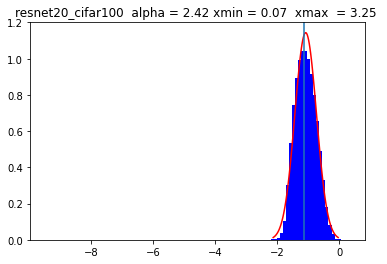

2.4206310835780833 0.10553787518200036 3.2518479038625303


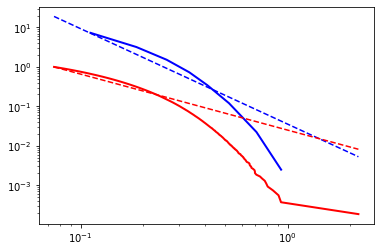

resnet56_cifar100
/content/drive/My Drive/J_resnets_fullsvd/JJMat_resnet56_cifar100.npy
2.7968931366344325 0.10333252563381196


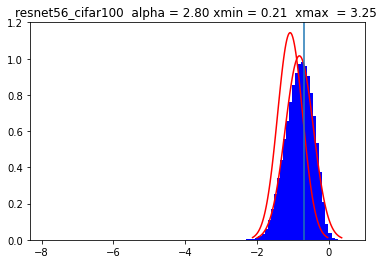

2.7968931366344325 0.10333252563381196 3.2518479038625303


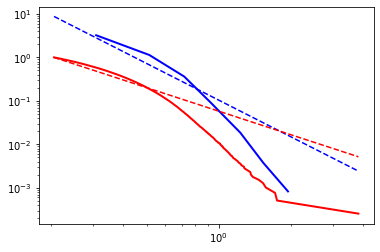

resnet110_cifar100
/content/drive/My Drive/J_resnets_fullsvd/JJMat_resnet110_cifar100.npy
2.5313025022699485 0.09667676290093508


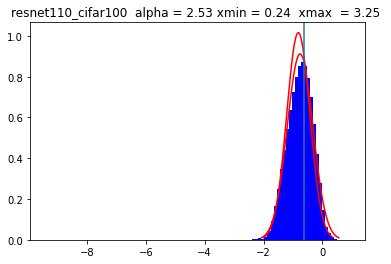

2.5313025022699485 0.09667676290093508 3.2518479038625303


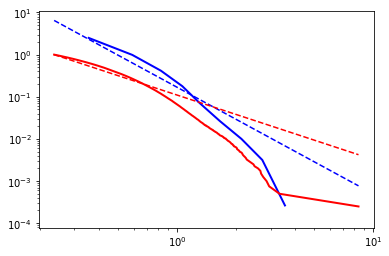

resnet164bn_cifar100
/content/drive/My Drive/J_resnets_fullsvd/JJMat_resnet164bn_cifar100.npy
2.6774156175077577 0.09498198600637603


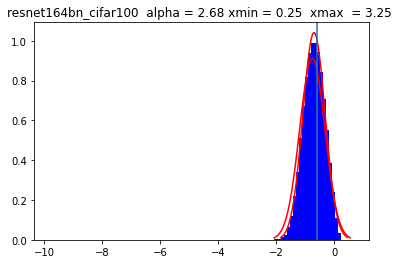

2.6774156175077577 0.09498198600637603 3.2518479038625303


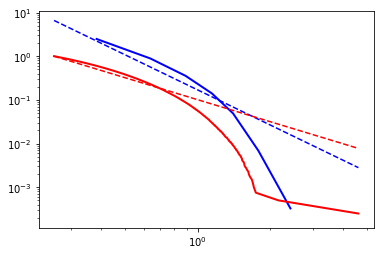

resnet272bn_cifar100
/content/drive/My Drive/J_resnets_fullsvd/JJMat_resnet272bn_cifar100.npy
2.588893025023337 0.09804925983488094


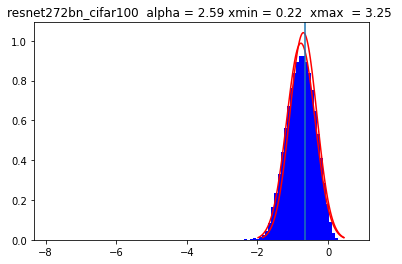

2.588893025023337 0.09804925983488094 3.2518479038625303


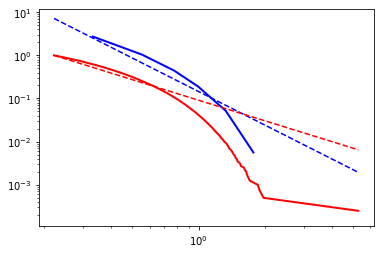

resnet542bn_cifar100
/content/drive/My Drive/J_resnets_fullsvd/JJMat_resnet542bn_cifar100.npy
2.4825607099150124 0.10136291515925688


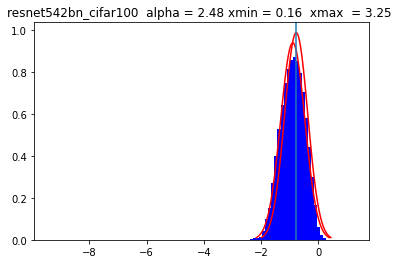

2.4825607099150124 0.10136291515925688 3.2518479038625303


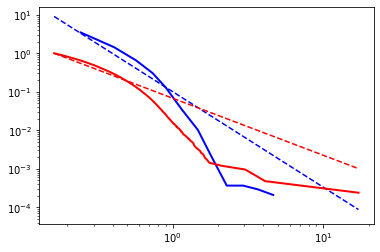

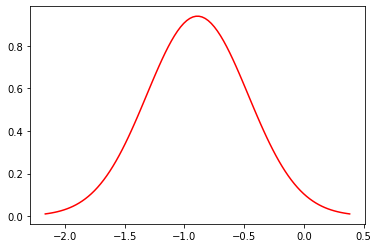

time: 13min 34s


In [153]:
import powerlaw

norm = (num_classes*3*32*32)

alphas = []
tail_alphas = []
max_evals = []
variances = []
JJnorms = []

for modelname in modelnames:
  print(modelname)
  filename = "{}/JJMat_{}.npy".format(Jdir, modelname)
  print(filename)
  JJMat = np.load(filename)

  JJMat =  (1.0/ norm)*JJMat
  JJnorms.append(np.linalg.norm(JJMat))

  norm = num_classes*3*32*32
  evals = np.linalg.eigh(JJMat)[0]   #LAPAK routine

  data = evals[evals > 0.0]
  logdata = np.log10(data)
  mu = np.mean(logdata)
  var = np.var(logdata)
  sigma = np.sqrt(var)

  idx = np.argmax(logdata)
  hist = plt.hist(logdata, bins=100, color='b', density=True)
  ih = np.argmax(hist[0])+1
  hmax = hist[1][ih]

  xmin = 10**hmax
  fit = powerlaw.Fit(data, xmin=xmin)

  alpha = fit.alpha
  D = fit.D
  diag_alphas.append(alpha)
  print(alpha, D)

  x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
  plt.plot(x, stats.norm.pdf(x, mu, sigma), color='r')

  plt.axvline(x=hmax)
  plt.title("{}  alpha = {:0.2f} xmin = {:0.2f}  xmax  = {:0.2f} ".format(modelname, alpha, xmin, max_eval))
  plt.show()

  print(alpha, D, max_eval)
  alphas.append(alpha)
  max_evals.append(max_eval)
  variances.append(var)

  fig2 = fit.plot_pdf(color='b', linewidth=2)
  fit.power_law.plot_pdf(color='b', linestyle='--', ax=fig2)
  fit.plot_ccdf(color='r', linewidth=2, ax=fig2)
  fit.power_law.plot_ccdf(color='r', linestyle='--', ax=fig2)
  plt.show()


  x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
  plt.plot(x, stats.norm.pdf(x, mu, sigma), color='r')


  #fit = powerlaw.Fit(data, xmax=np.max(evals))
  #print("tail alpha = {:0.2f}".format(fit.alpha))
  #tail_alphas.append(fit.alpha)
  


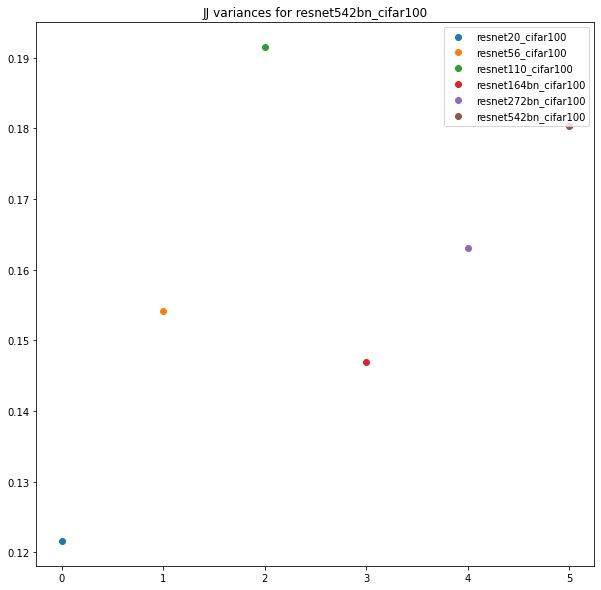

time: 217 ms


In [154]:
plt.figure(figsize=(10,10))
for im, modelname in enumerate(modelnames):
  plt.scatter(im, variances[im], label=modelname)
plt.title("JJ variances for {}".format(modelname))
plt.legend()
plt.show()

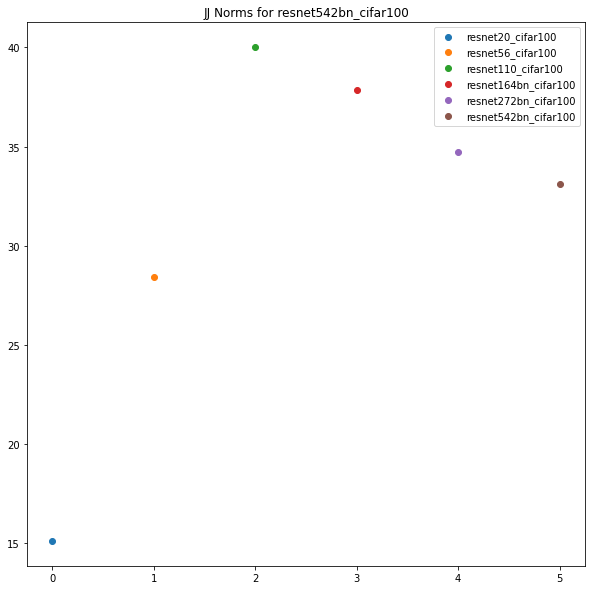

time: 210 ms


In [155]:
plt.figure(figsize=(10,10))
for im, modelname in enumerate(modelnames):
  plt.scatter(im, JJnorms[im], label=modelname)
plt.title("JJ Norms for {}".format(modelname))
plt.legend()
plt.show()

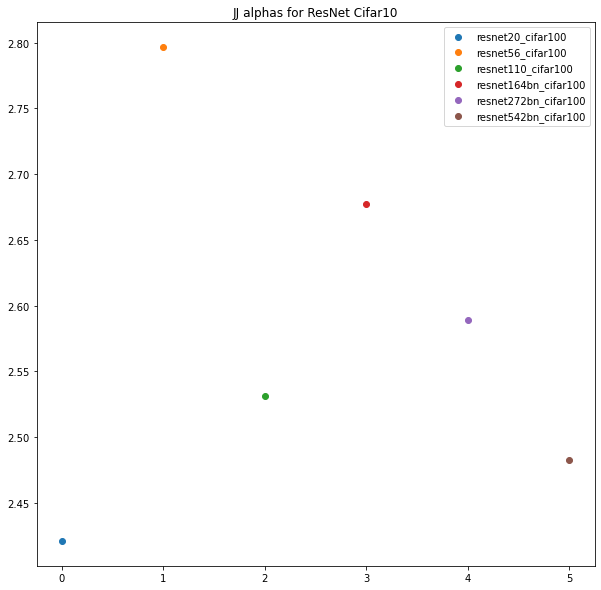

time: 226 ms


In [156]:
plt.figure(figsize=(10,10))
for im, modelname in enumerate(modelnames):
    plt.scatter(im, alphas[im], label=modelname)
plt.title(modelname)
plt.title("JJ alphas for {}".format("ResNet Cifar10"))
plt.legend()
plt.show()

In [157]:
xmin

0.16350055389189128

time: 2.92 ms


resnet20_cifar100
5.723316719745407 0.10517851216362456


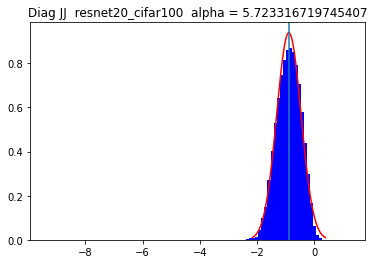

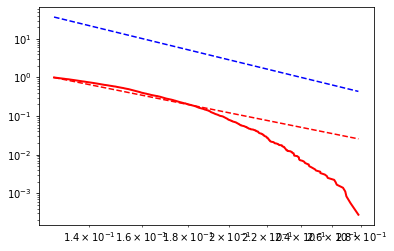

resnet56_cifar100
2.5232748042431394 0.19080431593451858


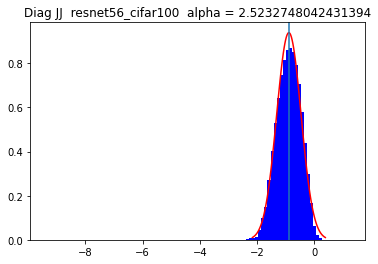

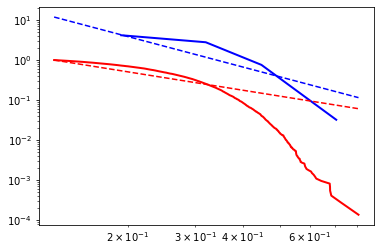

resnet110_cifar100
2.1900959138080056 0.17637479750840962


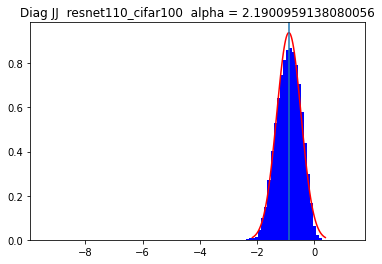

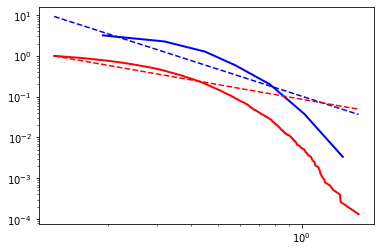

resnet164bn_cifar100
2.21824886287746 0.17682946446153402


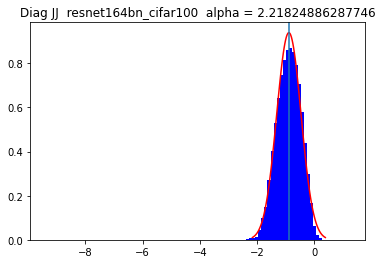

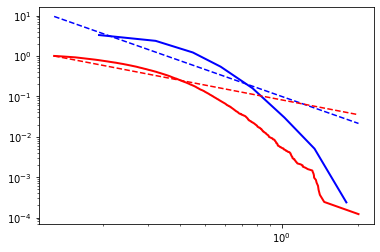

resnet272bn_cifar100
2.3040144283414934 0.1507325164816481


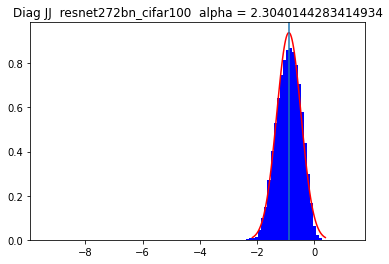

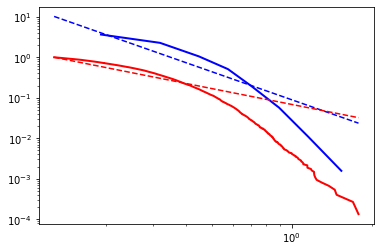

resnet542bn_cifar100
2.5631109583558676 0.1357000003118078


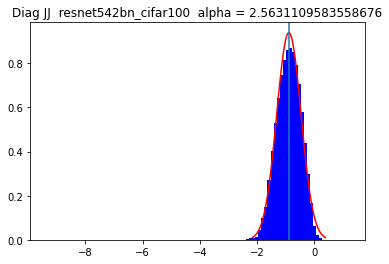

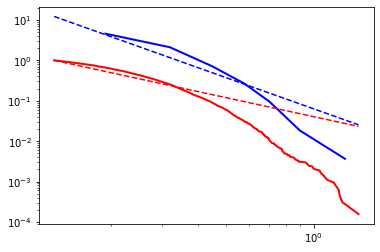

time: 12.6 s


In [158]:
diag_alphas = []

for modelname in modelnames:
  print(modelname)
  filename = "{}/JJMat_{}.npy".format(Jdir, modelname)
  JJMat = np.load(filename)
  JJMat =  (1.0/ norm)*JJMat

  JJDiag = np.diag(JJMat)
  data = JJDiag[JJDiag > 0.0]
  mu = np.mean(logdata)
  var = np.var(logdata)
  sigma = np.sqrt(var)

  idx = np.argmax(logdata)
  hist = plt.hist(logdata, bins=100, color='b', density=True)
  ih = np.argmax(hist[0])
  hmax = hist[1][ih]
  xmin = 10**hmax

  xmin = 10**hmax
  fit = powerlaw.Fit(data, xmin=xmin)

  alpha = fit.alpha
  D = fit.D
  diag_alphas.append(alpha)
  print(alpha, D)

  x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
  plt.plot(x, stats.norm.pdf(x, mu, sigma), color='r')

  plt.axvline(x=hmax)
  plt.title("Diag JJ  {}  alpha = {}".format(modelname,alpha))
  plt.show()

  fig2 = fit.plot_pdf(color='b', linewidth=2)
  fit.power_law.plot_pdf(color='b', linestyle='--', ax=fig2)
  fit.plot_ccdf(color='r', linewidth=2, ax=fig2)
  fit.power_law.plot_ccdf(color='r', linestyle='--', ax=fig2)
  plt.show()

  

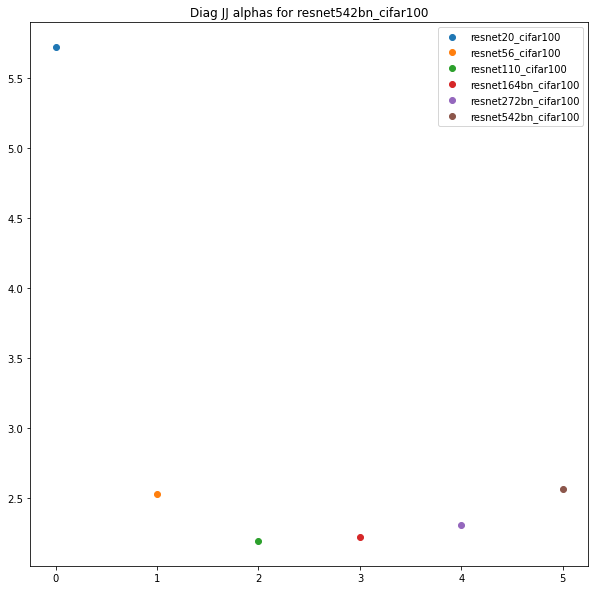

time: 207 ms


In [160]:
plt.figure(figsize=(10,10))
for im, modelname in enumerate(modelnames):
  if im !=6:
    plt.scatter(im, diag_alphas[im], label=modelname)
plt.title(modelname)
plt.title("Diag JJ alphas for {}".format(modelname))
plt.legend()
plt.show()

resnet20_cifar100
/content/drive/My Drive/J_resnets_fullsvd/JJMat_resnet20_cifar100.npy
resnet56_cifar100
/content/drive/My Drive/J_resnets_fullsvd/JJMat_resnet56_cifar100.npy
resnet110_cifar100
/content/drive/My Drive/J_resnets_fullsvd/JJMat_resnet110_cifar100.npy
resnet164bn_cifar100
/content/drive/My Drive/J_resnets_fullsvd/JJMat_resnet164bn_cifar100.npy
resnet272bn_cifar100
/content/drive/My Drive/J_resnets_fullsvd/JJMat_resnet272bn_cifar100.npy
resnet542bn_cifar100
/content/drive/My Drive/J_resnets_fullsvd/JJMat_resnet542bn_cifar100.npy


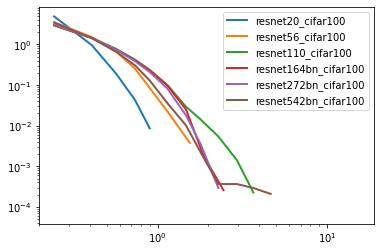

time: 13min 33s


In [162]:
import powerlaw

norm = (num_classes*3*32*32)

alphas = []
tail_alphas = []
max_evals = []
variances = []
JJnorms = []

for modelname in modelnames:
  print(modelname)
  filename = "{}/JJMat_{}.npy".format(Jdir, modelname)
  print(filename)
  JJMat = np.load(filename)

  JJMat =  (1.0/ norm)*JJMat
  JJnorms.append(np.linalg.norm(JJMat))

  norm = num_classes*3*32*32
  evals = np.linalg.eigh(JJMat)[0]   #LAPAK routine

  data = evals[evals > 0.0]
  logdata = np.log10(data)
  mu = np.mean(logdata)
  var = np.var(logdata)
  sigma = np.sqrt(var)

  idx = np.argmax(logdata)
  #hist = plt.hist(logdata, bins=100,  label=modelname)
  ih = np.argmax(hist[0])+1
  hmax = hist[1][ih]

  xmin = 10**hmax
  fit = powerlaw.Fit(data, xmin=xmin)
  fig2 = fit.plot_pdf(linewidth=2, label=modelname)

plt.legend()